In [25]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import os
from pydataset import data
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier


import matplotlib.pyplot as plt
import seaborn as sns

# import our own acquire module
import acquire
import env
import prepare

Create a new notebook, random_forests, and work with titanic data to do the following:

In [2]:
directory = os.getcwd()

titanic_query = 'select * from passengers'
titanic = acquire.get_titanic_data(titanic_query, directory, filename = 'titanic.csv')
titanic.head()

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,3,male,22.0,1,0,7.2500,S,Third,None,Southampton,0
1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0
2,2,1,3,female,26.0,0,0,7.9250,S,Third,None,Southampton,1
3,3,1,1,female,35.0,1,0,53.1000,S,First,C,Southampton,0
4,4,0,3,male,35.0,0,0,8.0500,S,Third,None,Southampton,1


Fit the Random Forest classifier to your training sample and transform (i.e. make predictions on the training sample) setting the random_state accordingly and setting min_samples_leaf = 1 and max_depth = 10.

In [3]:
from prepare import wrangle_data

train, val, test = prepare.split_data(prepare.wrangle_data('titanic'), 'titanic')
train.head()

,survived,pclass,sex,age,sibsp,parch,fare,embark_town,alone
474,0,3,female,22.0,0,0,9.8375,Southampton,1
370,1,1,male,25.0,1,0,55.4417,Cherbourg,0
573,1,3,female,30.0,0,0,7.7500,Queenstown,1
110,0,1,male,47.0,0,0,52.0000,Southampton,1
167,0,3,female,45.0,1,4,27.9000,Southampton,0


In [10]:
train, validate, test = prepare.split_data(prepare.wrangle_data('titanic'), 'titanic')

In [15]:
train, validate, test = preprocess_titanic(train, val, test)
train.head()

,survived,pclass,sibsp,parch,alone,is_queenstown,is_southampton,age_scaled,fare_scaled,is_female
474,0,3,0,0,1,0,1,0.303285,0.019202,1
370,1,1,1,0,0,0,0,0.345941,0.108215,0
573,1,3,0,0,1,1,0,0.417034,0.015127,1
110,0,1,0,0,1,0,1,0.658752,0.101497,0
167,0,3,1,4,0,0,1,0.630314,0.054457,1


In [16]:
X_train = train.drop(columns=["survived"])
y_train = train.survived

X_validate = validate.drop(columns=["survived"])
y_validate = validate.survived

X_test = test.drop(columns=["survived"])
y_test = test.survived

In [17]:
X_train.shape, X_validate.shape, X_test.shape

((498, 9), (214, 9), (179, 9))

In [18]:
X_train.head()

,pclass,sibsp,parch,alone,is_queenstown,is_southampton,age_scaled,fare_scaled,is_female
474,3,0,0,1,0,1,0.303285,0.019202,1
370,1,1,0,0,0,0,0.345941,0.108215,0
573,3,0,0,1,1,0,0.417034,0.015127,1
110,1,0,0,1,0,1,0.658752,0.101497,0
167,3,1,4,0,0,1,0.630314,0.054457,1


In [21]:
# The mode is a great baseline
baseline = y_train.mode()

# Produce a boolean array with True representing a match between the baseline prediction and reality
matches_baseline_prediction = y_train == 0

baseline_accuracy = matches_baseline_prediction.mean()
print(f"Baseline accuracy: {round(baseline_accuracy, 2)}")

Baseline accuracy: 0.62


In [26]:
# Make the model
forest1 = RandomForestClassifier(max_depth=1, random_state=123)

# Fit the model (on train and only train)
forest1.fit(X_train, y_train)

# Use the model
# We'll evaluate the model's performance on train, first
y_predictions = forest1.predict(X_train)

# Produce the classification report on the actual y values and this model's predicted y values
report = classification_report(y_train, y_predictions, output_dict=True)
print("Tree of 1 depth")
pd.DataFrame(report)

Tree of 1 depth


,0,1,accuracy,macro avg,weighted avg
precision,0.759259,0.833333,0.777108,0.796296,0.787669
recall,0.934853,0.523560,0.777108,0.729207,0.777108
f1-score,0.837956,0.643087,0.777108,0.740522,0.763217
support,307.000000,191.000000,0.777108,498.000000,498.000000


In [27]:
# sklearn confusion matrix
pd.DataFrame(confusion_matrix(y_predictions, y_train))

,0,1
0,287,91
1,20,100


In [29]:
TN, FP, FN, TP = confusion_matrix(y_train,y_predictions).ravel()
ALL = TP + TN + FP + FN

TP, TN, FP, FN

(100, 287, 20, 91)

In [30]:
accuracy = (TP + TN)/ALL
print(f"Accuracy: {accuracy}")

true_positive_rate = TP/(TP+FN)
print(f"True Positive Rate: {true_positive_rate}")

false_positive_rate = FP/(FP+TN)
print(f"False Positive Rate: {false_positive_rate}")

true_negative_rate = TN/(TN+FP)
print(f"True Negative Rate: {true_negative_rate}")

false_negative_rate = FN/(FN+TP)
print(f"False Negative Rate: {false_negative_rate}")

precision = TP/(TP+FP)
print(f"Precision: {precision}")

recall = TP/(TP+FN)
print(f"Recall: {recall}")

f1_score = 2*(precision*recall)/(precision+recall)
print(f"F1 Score: {f1_score}")

support_pos = TP + FN
print(f"Support (0): {support_pos}")

support_neg = FP + TN
print(f"Support (1): {support_neg}")

Accuracy: 0.7771084337349398
True Positive Rate: 0.5235602094240838
False Positive Rate: 0.06514657980456026
True Negative Rate: 0.9348534201954397
False Negative Rate: 0.47643979057591623
Precision: 0.8333333333333334
Recall: 0.5235602094240838
F1 Score: 0.6430868167202572
Support (0): 191
Support (1): 307


In [31]:
for i in range(2, 11):
    # Make the model
    forest = RandomForestClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    y_predictions = forest.predict(X_train)

    # Produce the classification report on the actual y values and this model's predicted y values
    report = classification_report(y_train, y_predictions, output_dict=True)
    print(f"Tree with max depth of {i}")
    print(pd.DataFrame(report))
    print()

Tree with max depth of 2
                    0           1  accuracy   macro avg  weighted avg
precision    0.788462    0.850746  0.805221    0.819604      0.812350
recall       0.934853    0.596859  0.805221    0.765856      0.805221
f1-score     0.855440    0.701538  0.805221    0.778489      0.796413
support    307.000000  191.000000  0.805221  498.000000    498.000000

Tree with max depth of 3
                    0           1  accuracy   macro avg  weighted avg
precision    0.844118    0.873418  0.853414    0.858768      0.855355
recall       0.934853    0.722513  0.853414    0.828683      0.853414
f1-score     0.887172    0.790831  0.853414    0.839001      0.850222
support    307.000000  191.000000  0.853414  498.000000    498.000000

Tree with max depth of 4
                    0           1  accuracy   macro avg  weighted avg
precision    0.849711    0.914474  0.869478    0.882092      0.874550
recall       0.957655    0.727749  0.869478    0.842702      0.869478
f1-score     

Evaluate your results using the model score, confusion matrix, and classification report.

In [32]:
metrics = []

for i in range(2, 25):
    # Make the model
    forest = RandomForestClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = forest.score(X_train, y_train)
    
    out_of_sample_accuracy = forest.score(X_validate, y_validate)

    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,max_depth,train_accuracy,validate_accuracy,difference
0,2,0.805221,0.747664,0.057557
1,3,0.853414,0.775701,0.077713
2,4,0.869478,0.789720,0.079758
3,5,0.889558,0.789720,0.099839
4,6,0.899598,0.785047,0.114552
5,7,0.917671,0.803738,0.113932
6,8,0.933735,0.794393,0.139342
7,9,0.945783,0.785047,0.160736
8,10,0.963855,0.766355,0.197500
9,11,0.967871,0.785047,0.182825


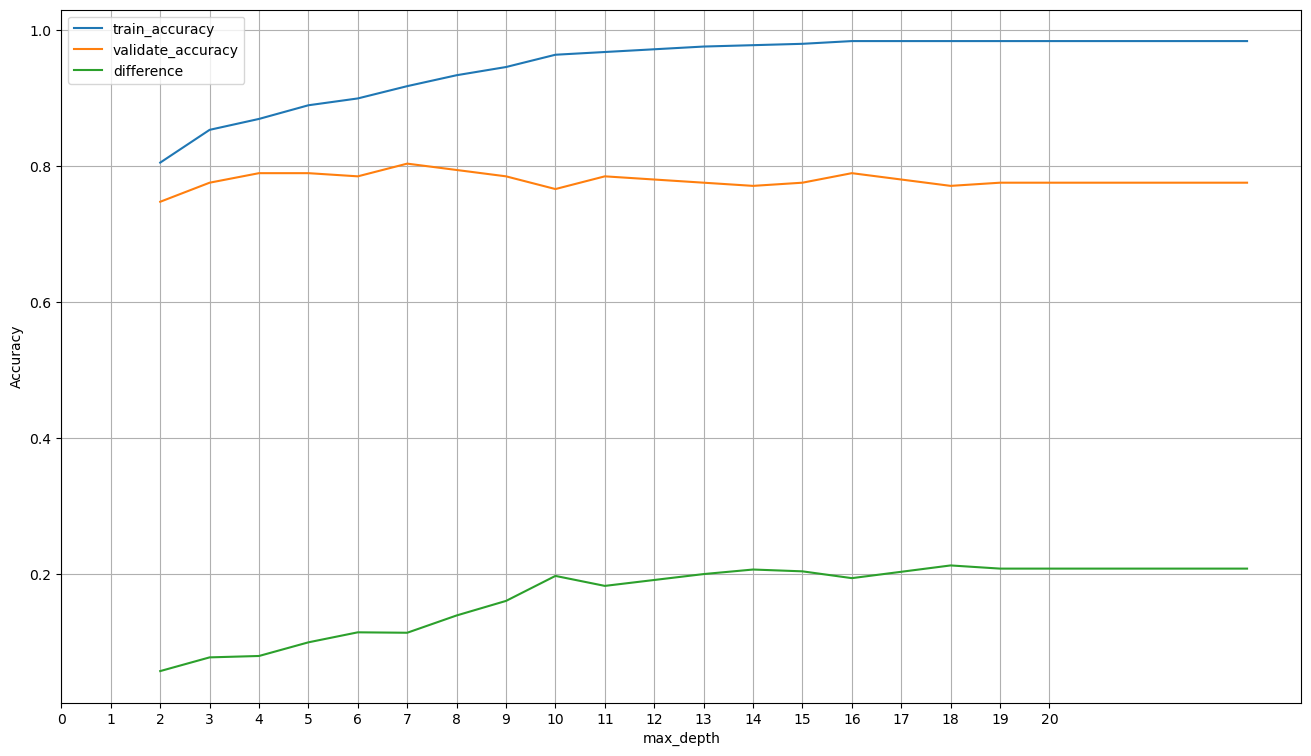

In [33]:
df.set_index('max_depth').plot(figsize = (16,9))
plt.ylabel('Accuracy')
plt.xticks(np.arange(0,21,1))
plt.grid()

In [34]:
# Let's continue getting loopy, so we can compare in-sample to out-of-sample
metrics = []
max_depth = 20

for i in range(2, max_depth):
    # Make the model
    depth = max_depth - i
    n_samples = i
    forest = RandomForestClassifier(max_depth=depth, min_samples_leaf=n_samples, random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = forest.score(X_train, y_train)
    
    out_of_sample_accuracy = forest.score(X_validate, y_validate)

    output = {
        "min_samples_per_leaf": n_samples,
        "max_depth": depth,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,min_samples_per_leaf,max_depth,train_accuracy,validate_accuracy,difference
0,2,18,0.915663,0.789720,0.125943
1,3,17,0.895582,0.799065,0.096517
2,4,16,0.877510,0.789720,0.087790
3,5,15,0.875502,0.794393,0.081109
4,6,14,0.869478,0.771028,0.098450
5,7,13,0.859438,0.771028,0.088410
6,8,12,0.859438,0.771028,0.088410
7,9,11,0.857430,0.775701,0.081729
8,10,10,0.859438,0.742991,0.116447
9,11,9,0.857430,0.766355,0.091075


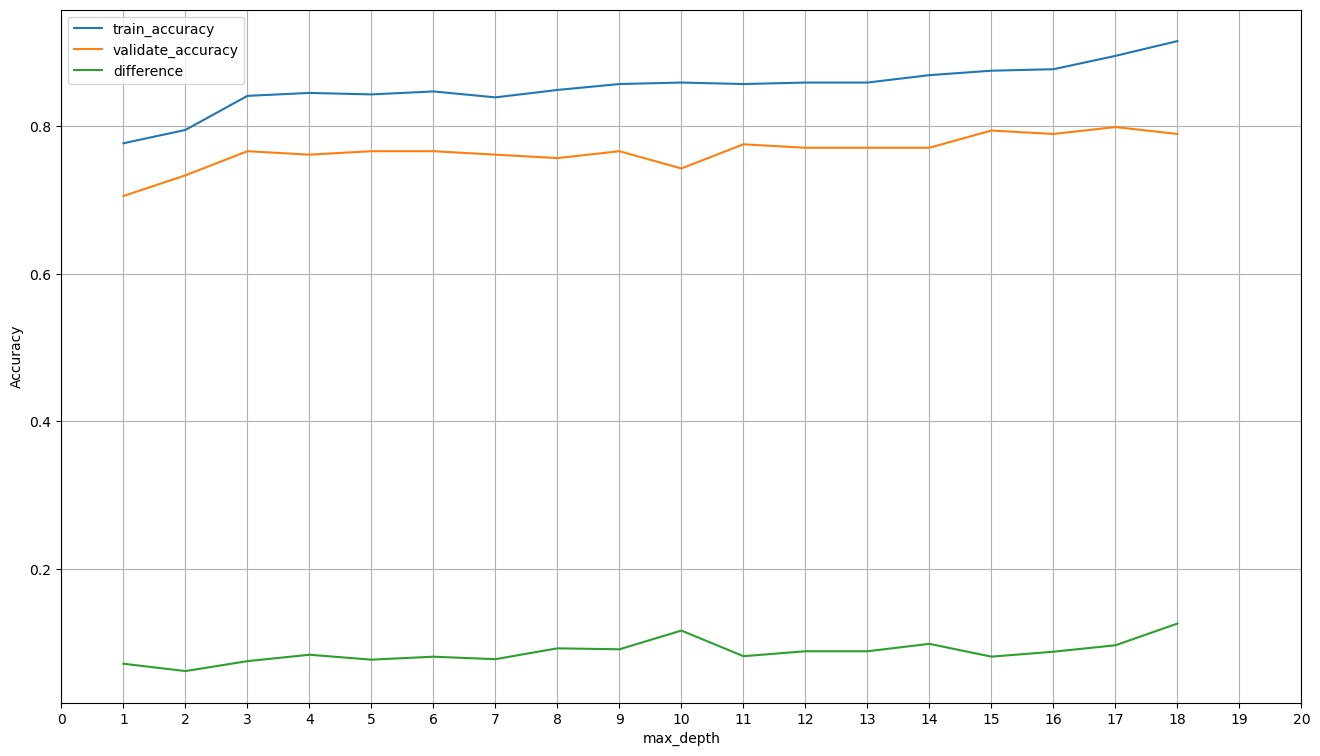

In [35]:
df.set_index('max_depth')[['train_accuracy', 'validate_accuracy','difference']].plot(figsize = (16,9))
plt.ylabel('Accuracy')
plt.xticks(np.arange(0,21,1))
plt.grid()

In [36]:
# Let's continue getting loopy, so we can compare in-sample to out-of-sample
metrics = []
max_depth = 20

for i in range(2, max_depth):
    # Make the model
    depth = i
    n_samples = i
    forest = RandomForestClassifier(max_depth=depth, min_samples_leaf=n_samples, random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = forest.score(X_train, y_train)
    
    out_of_sample_accuracy = forest.score(X_validate, y_validate)

    output = {
        "min_samples_per_leaf": n_samples,
        "max_depth": depth,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,min_samples_per_leaf,max_depth,train_accuracy,validate_accuracy,difference
0,2,2,0.805221,0.747664,0.057557
1,3,3,0.855422,0.771028,0.084394
2,4,4,0.857430,0.780374,0.077056
3,5,5,0.865462,0.771028,0.094434
4,6,6,0.865462,0.775701,0.089761
5,7,7,0.861446,0.775701,0.085745
6,8,8,0.857430,0.775701,0.081729
7,9,9,0.859438,0.761682,0.097756
8,10,10,0.859438,0.742991,0.116447
9,11,11,0.859438,0.761682,0.097756


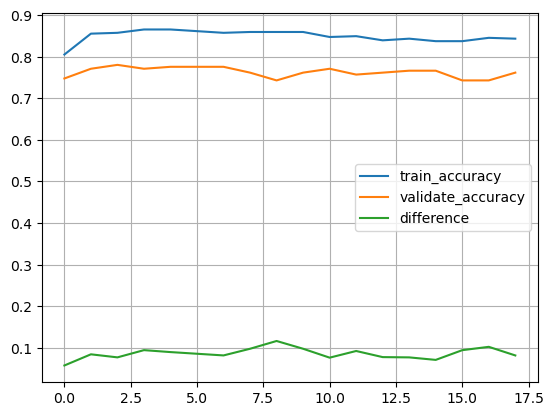

In [37]:
df[['train_accuracy', 'validate_accuracy','difference']].plot()
plt.grid()

In [38]:
# Let's continue getting loopy, so we can compare in-sample to out-of-sample
metrics = []


for i in range(2, 50):
    # Make the model
    depth = 5
    n_samples = i
    forest = RandomForestClassifier(max_depth=depth, min_samples_leaf=n_samples, random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = forest.score(X_train, y_train)
    
    out_of_sample_accuracy = forest.score(X_validate, y_validate)

    output = {
        "min_samples_per_leaf": n_samples,
        "max_depth": depth,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,min_samples_per_leaf,max_depth,train_accuracy,validate_accuracy,difference
0,2,5,0.877510,0.785047,0.092463
1,3,5,0.871486,0.789720,0.081766
2,4,5,0.863454,0.780374,0.083080
3,5,5,0.865462,0.771028,0.094434
4,6,5,0.859438,0.771028,0.088410
5,7,5,0.857430,0.775701,0.081729
6,8,5,0.865462,0.761682,0.103780
7,9,5,0.859438,0.766355,0.093083
8,10,5,0.855422,0.766355,0.089067
9,11,5,0.855422,0.780374,0.075048


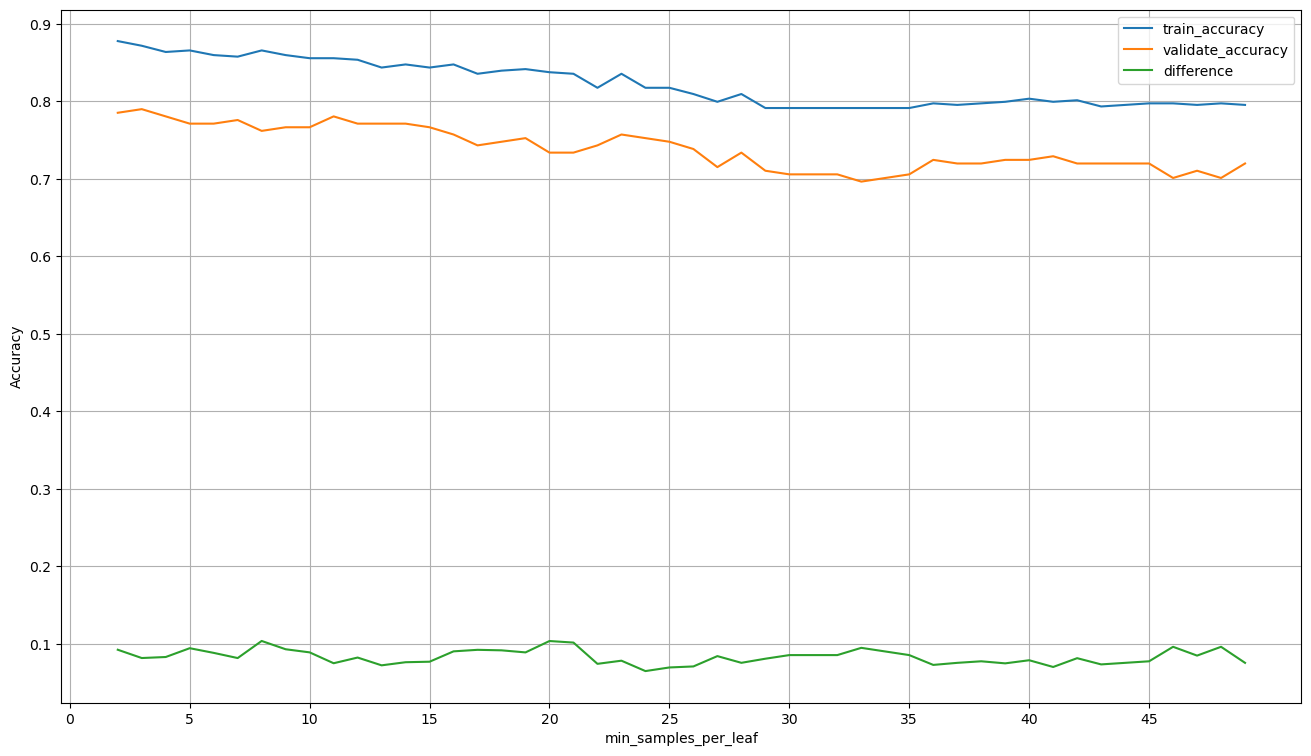

In [39]:
df.set_index('min_samples_per_leaf')[['train_accuracy', 'validate_accuracy', 'difference']].plot(figsize = (16,9))
plt.ylabel('Accuracy')
plt.xticks(np.arange(0,50,5))
plt.grid()